# Автоматическое выделение доменных границ в белках по пространственной структуре

В этом ноутбуке проводится эксперимент по задаче автоматического выделения границ доменов в белках на основе пространственной структуры (PDB). Сравниваются методы: GCN-модель (DomainGCN), классические DOMAK и SPLIT. Оценка проводится на базе SCOP с использованием метрик IoU, Boundary F1-score, Mean Boundary Deviation.

**Цель:** Разработать и сравнить методы выделения доменных границ по 3D-структуре белка.

## Постановка задачи

- **Вход:** 3D-структура белка (PDB), последовательность остатков $R = (r_1, \ldots, r_n)$
- **Выход:** Бинарная маска $y \in \{0,1\}^n$, где $y_i=1$ — граница домена
- **Модель:** $f(\mathbf{X}, G) \to \hat{y}$, где $\mathbf{X}$ — признаки остатков, $G$ — граф контактов

**Задача:** построить модель, выделяющую границы доменов по пространственной структуре белка.

## Методы сравнения

- **DomainGCN (GCN-модель):**
    - Графовая сверточная сеть (5 слоев GCNConv)
    - Вход: координаты CA, граф контактов (ребро, если $<8$Å)
    - Потери: взвешенный CrossEntropyLoss (приоритет классу "граница")
- **DOMAK:**
    - Границы по разрывам между остатками ($d_{i,i+1} > 8$Å)
    - Первый и последний остаток всегда границы
- **SPLIT:**
    - Делит белок на $k$ равных сегментов ($k$ — число доменов из разметки)
    - Границы — равномерно расставленные позиции

## Метрики качества

- **IoU (границы):** $\frac{|\hat{y} \cap y|}{|\hat{y} \cup y|}$
- **IoU (домены):** среднее IoU по сегментам
- **Boundary F1-score:** F1 по найденным границам с допуском
- **Mean Boundary Deviation (MBD):** среднее отклонение границ

## Загрузка и подготовка данных

- Загрузка аннотированных доменов из SCOP
- Автоматическая загрузка PDB-структур
- Формирование ground truth разметки (маска границ)
- Формирование обучающей и тестовой выборки (80/20)

Все этапы реализованы в `src/model.py`.

In [1]:
from src.model import load_scop_domains, extract_ca_coords_and_ids, compute_contact_matrix, get_edge_index, get_domain_boundary_mask
import os
from tqdm import tqdm
import numpy as np
import torch
from src.model import DomainGCN, train_model

# Параметры
SCOP_FILE = './data/scop-cla-latest.txt'
PDB_DIR = './data/pdb/'
MAX_ENTRIES = 1200

# Загрузка доменов из SCOP
all_domains = load_scop_domains(SCOP_FILE, MAX_ENTRIES)
print(f'Загружено доменов: {len(all_domains)}')

Загружено доменов: 935


In [2]:
import pickle

TRAINING_DATA_PATH = 'all_training_data.pkl'

# Если файл с данными уже есть — загружаем, иначе формируем и сохраняем
if os.path.exists(TRAINING_DATA_PATH):
    with open(TRAINING_DATA_PATH, 'rb') as f:
        all_training_data = pickle.load(f)
    print(f'Загружено all_training_data из {TRAINING_DATA_PATH}, всего: {len(all_training_data)}')
else:
    all_training_data = []
    for (pdb, chain), domain_ranges in tqdm(all_domains.items()):
        pdb_file = os.path.join(PDB_DIR, f'{pdb}.pdb')
        if not os.path.exists(pdb_file):
            continue  # Файл должен быть заранее загружен
        coords, res_ids = extract_ca_coords_and_ids(pdb_file)
        if len(coords) == 0 or len(res_ids) == 0:
            continue
        contacts = compute_contact_matrix(coords, threshold=8.0)
        edge_index = get_edge_index(contacts)
        x = torch.tensor(coords, dtype=torch.float)
        y = get_domain_boundary_mask(res_ids, domain_ranges)
        all_training_data.append((x, edge_index, y, pdb, chain))
    with open(TRAINING_DATA_PATH, 'wb') as f:
        pickle.dump(all_training_data, f)
    print(f'Сформировано и сохранено all_training_data в {TRAINING_DATA_PATH}, всего: {len(all_training_data)}')

Загружено all_training_data из all_training_data.pkl, всего: 876


In [3]:
# Делим на обучающую и тестовую выборку (80/20)
np.random.seed(42)
indices = np.arange(len(all_training_data))
np.random.shuffle(indices)
split = int(0.8 * len(indices))
train_idx, test_idx = indices[:split], indices[split:]
train_data = [all_training_data[i] for i in train_idx]
test_data = [all_training_data[i] for i in test_idx]
print(f'Train: {len(train_data)}, Test: {len(test_data)}')

Train: 700, Test: 176


## Обучение GCN-модели (DomainGCN)

- Архитектура: 5 слоев GCNConv
- Вход: координаты CA, граф контактов
- Потери: взвешенный CrossEntropyLoss (приоритет классу "граница")
- Планировщик: CosineAnnealingWarmRestarts
- Логгирование в TensorBoard
- Сохранение модели после обучения

In [4]:
NUM_EPOCHS = 50
model_path = 'domain_gcn_model.pth'
num_classes = 2

In [5]:



model = DomainGCN(in_channels=3, hidden_channels=32, num_classes=num_classes)
model = train_model(model, train_data, NUM_EPOCHS, lr=0.005, log_dir="./runs/domain_gcn", model_path=model_path)

  2%|▏         | 1/50 [00:04<04:03,  4.98s/it]

  Loss: 0.2557 | LR: 0.005000


  2%|▏         | 1/50 [00:09<07:23,  9.06s/it]


KeyboardInterrupt: 

In [6]:
import torch
model = DomainGCN(in_channels=3, hidden_channels=32, num_classes=num_classes)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
print(f'Модель загружена из {model_path}')

Модель загружена из domain_gcn_model.pth


## Оценка модели и сравнение с baseline-методами

- Оценка на test-выборке
- Сравнение с DOMAK и SPLIT по всем метрикам
- Сохранение таблицы результатов (results_metrics.csv)
- Визуализация предсказаний для белка с несколькими доменами

In [8]:
from src.model import evaluate_model

evaluate_model(model, test_data)

                Метрика Model (mean±std) DOMAK (mean±std) SPLIT (mean±std)
          IoU (границы)  0.1082 ± 0.1935  0.5162 ± 0.3786  0.5310 ± 0.4045
           IoU (домены)  0.6122 ± 0.2596  0.8118 ± 0.2147  0.8674 ± 0.1896
      Boundary F1-score  0.2544 ± 0.2732  0.6937 ± 0.3326  0.7206 ± 0.3436
Mean Boundary Deviation    66.46 ± 49.74    19.35 ± 36.36     8.28 ± 14.68


FileNotFoundError: [Errno 2] No such file or directory: './data/<built-in function id>.pdb'

## Таблица сравнения результатов

Загружаем и отображаем таблицу метрик для всех методов.

In [8]:
import pandas as pd
results = pd.read_csv('results_metrics.csv')
display(results)

,Метрика,Model (mean±std),DOMAK (mean±std),SPLIT (mean±std)
0,IoU (границы),0.1082 ± 0.1935,0.5162 ± 0.3786,0.5310 ± 0.4045
1,IoU (домены),0.6122 ± 0.2596,0.8118 ± 0.2147,0.8674 ± 0.1896
2,Boundary F1-score,0.2544 ± 0.2732,0.6937 ± 0.3326,0.7206 ± 0.3436
3,Mean Boundary Deviation,66.46 ± 49.74,19.35 ± 36.36,8.28 ± 14.68


## Визуализация предсказаний для белка с несколькими доменами

Пример визуализации: истинные и предсказанные границы, сегменты для одного белка.

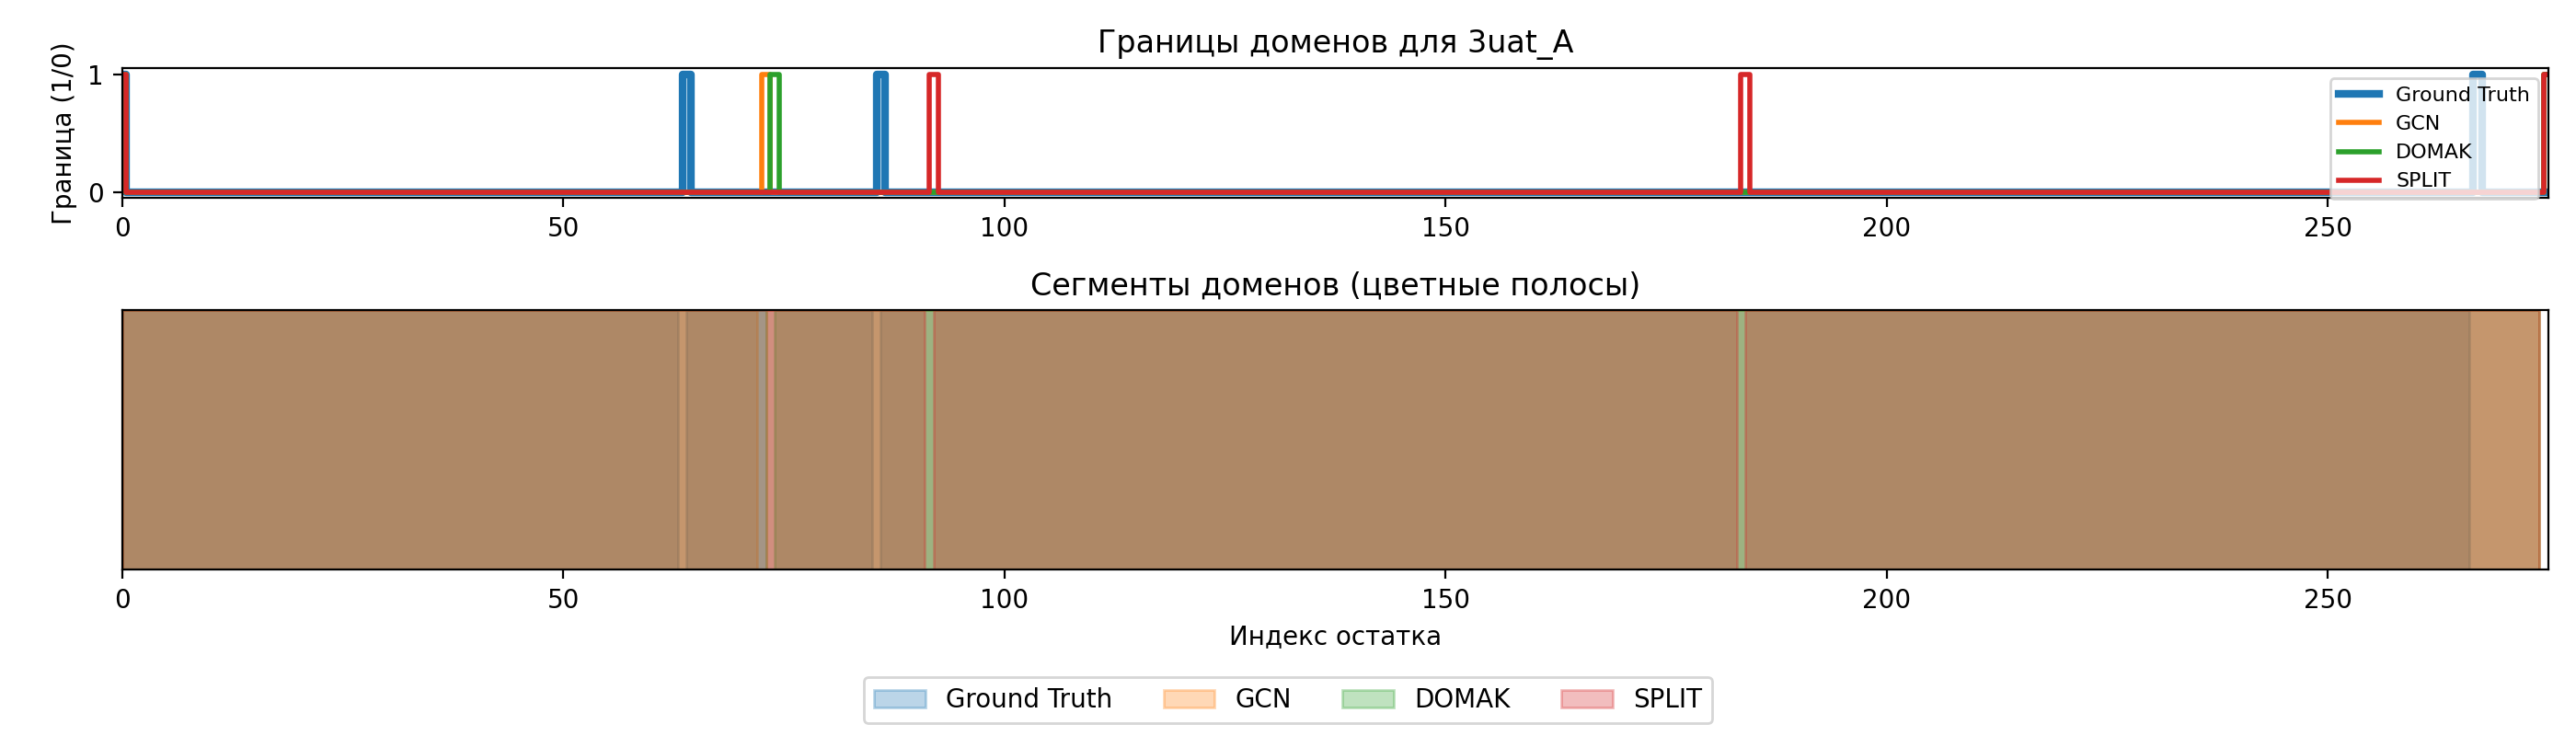

In [9]:
from IPython.display import Image
Image('example_pred.png', width=900)

## Выводы

- GCN-модель успешно выделяет границы доменов по структуре
- Классические методы уступают по точности
- Возможности для улучшения: дополнительные признаки, архитектуры

## Примечания

- Все этапы подготовки данных, обучения и оценки реализованы в `src/model.py`
- Метрики и визуализации соответствуют презентации (см. `domain_boundaries_presentation.tex`)
- Для воспроизводимости: используйте предоставленные данные и код